In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install rouge-score

In [ ]:
import torch
import json
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import nltk
import spacy
import string
import evaluate  # Bleu
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pandas as pd
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
import seaborn as sns
sns.set_style("whitegrid")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
#MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel"    # fine-tuned model (epochs: 16)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel2"    # fine-tuned model (epochs: 75)
# Set up the tokenizer
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.00001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Custom dataset

In [7]:
class MedQADataset(Dataset):
    def __init__(self, tokenizer, dataframe, q_len, t_len):
        self.tokenizer = tokenizer
        self.q_len = q_len
        self.t_len = t_len
        self.data = dataframe
        self.questions = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data['answer']

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = f"Вопрос: {self.questions[idx]}"
        context = f"Контекст: {self.context[idx]}"
        answer = f"Ответ: {self.answer[idx]}"

        question_tokenized = self.tokenizer(
            question,
            context,
            max_length=self.q_len,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        answer_tokenized = self.tokenizer(
            answer,
            max_length=self.t_len,
            padding="max_length",
            truncation=True,
            pad_to_max_length=True,
            add_special_tokens=True
        )

        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100

        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }

### Read the data

In [8]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_Rus_clean.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer,answer_start
0,что вызывает синдром нунан?,"синдром нунан это заболевание, присутствующее ...",синдром нунан связан с дефектами нескольких ге...,0
1,каковы осложнения синдрома нунан?,"синдром нунан это заболевание, присутствующее ...",накопление жидкости в тканях организма (лимфе...,-1
2,как предотвратить синдром нунан?,"синдром нунан это заболевание, присутствующее ...","пары с семейным анамнезом синдрома нунан, возм...",2184
3,что такое синдром нунан?,"синдром нунан это заболевание, присутствующее ...","синдром нунан – это заболевание, которое может...",0
4,что такое целиакия – вопросы питания? (также ...,"целиакия это иммунное заболевание, передающеес...","целиакия – это иммунное заболевание, передающе...",0
...,...,...,...,...
992,что такое дефицит аденозинмонофосфатдезаминаз...,описание дефицит аденозинмонофосфатдезаминазы ...,дефицит аденозинмонофосфат (амф) дезаминазы эт...,12
993,сколько людей страдают от дефицита аденозинмо...,описание дефицит аденозинмонофосфатдезаминазы ...,дефицит амфдезаминазы является одним из наибол...,174
994,"каковы генетические изменения, связанные с де...",описание дефицит аденозинмонофосфатдезаминазы ...,мутации в гене ampd1 вызывают дефицит ampдезам...,1495
995,наследуется ли дефицит аденозинмонофосфатдеза...,описание дефицит аденозинмонофосфатдезаминазы ...,это состояние наследуется по аутосомнорецессив...,1346


#### Example

In [9]:
sample = data.iloc[1]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=32,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [10]:
output.loss

tensor(3.7182, grad_fn=<NllLossBackward0>)

### Dataloader

In [11]:
#data = data[:200]

train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)
#scheduler = None

Train shape: (781, 4)
Validation shape: (196, 4)
Test shape: (20, 4)


### Training and validation loop



In [ ]:
MODEL = MODEL.to(DEVICE)
N_EPOCHS = 84

best_val_loss = float('inf')
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel2'

train_loss_lst = []
val_loss_lst = []

for epoch in range(N_EPOCHS):
    train_loss = 0.0
    MODEL.train()
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
        # Clear gradients
        OPTIMIZER.zero_grad()
        # Make a prediction
        outputs = MODEL(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        # Calculate gradients
        outputs.loss.backward()
        # Update weights
        OPTIMIZER.step()
        # Calculate losss
        train_loss += outputs.loss.item()
        #train_batch_count += 1

    if scheduler is not None:
        scheduler.step(train_loss/len(train_loader))

    #Evaluation
    val_loss = 0.0
    MODEL.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation batches"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)

            outputs = MODEL(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask
            )
            val_loss += outputs.loss.item()

    train_loss_lst.append(train_loss / len(train_loader))
    val_loss_lst.append(val_loss / len(val_loader))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        MODEL.save_pretrained(STATE_DICT_PATH)
        TOKENIZER.save_pretrained(STATE_DICT_PATH)

    print(f'Epoch: {epoch}\t\tTrain loss: {train_loss/len(train_loader)}\t\t'
          f'Validation loss: {val_loss/len(val_loader)}')

Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 0		Train loss: 3.7368569264606553		Validation loss: 1.965740896001154


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 1		Train loss: 2.9697694814935023		Validation loss: 1.7901534620596438


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 2		Train loss: 2.709828962476886		Validation loss: 1.7393182966173912


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 3		Train loss: 2.5563593068901374		Validation loss: 1.649973523860075


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 4		Train loss: 2.43341917468577		Validation loss: 1.6248456507313007


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 5		Train loss: 2.3274857079496187		Validation loss: 1.5811210627458534


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 6		Train loss: 2.2527311724059436		Validation loss: 1.512347010933623


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 7		Train loss: 2.1752218719647853		Validation loss: 1.494481131738546


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 8		Train loss: 2.1212784872979533		Validation loss: 1.4621303981664229


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


Epoch: 9		Train loss: 2.077151131873228		Validation loss: 1.4553315019120976


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


Epoch: 10		Train loss: 2.0080573820337957		Validation loss: 1.428671004820843


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Epoch: 11		Train loss: 1.9652139301202736		Validation loss: 1.411058254387914


Validation batches: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


Epoch: 12		Train loss: 1.922305549589955		Validation loss: 1.3786501781064637


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 13		Train loss: 1.8705459796652502		Validation loss: 1.3528181582081074


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 14		Train loss: 1.9020639703590043		Validation loss: 1.3178581114934416


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 15		Train loss: 1.8400898353785884		Validation loss: 1.335993156749375


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Epoch: 16		Train loss: 1.7953704181982546		Validation loss: 1.2992839679426076


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 17		Train loss: 1.760665467199014		Validation loss: 1.2883445450237818


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 18		Train loss: 1.735960845740474		Validation loss: 1.2734639912235493


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 19		Train loss: 1.7072144841053047		Validation loss: 1.26495296918616


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 20		Train loss: 1.6904120360101973		Validation loss: 1.2493267150557772


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 21		Train loss: 1.6595088307346617		Validation loss: 1.2166262256855866


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 22		Train loss: 1.65438370710733		Validation loss: 1.2125323037711941


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 23		Train loss: 1.6187490075826645		Validation loss: 1.204169432727658


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 24		Train loss: 1.582881943607817		Validation loss: 1.159055459256075


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 25		Train loss: 1.5691463846941383		Validation loss: 1.160163246247233


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 26		Train loss: 1.5608706057679897		Validation loss: 1.1418326132151546


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 27		Train loss: 1.5270129896852436		Validation loss: 1.1406548534120833


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 28		Train loss: 1.5192281533868945		Validation loss: 1.1175058189095284


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 29		Train loss: 1.4802541687172286		Validation loss: 1.1110988879690364


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 30		Train loss: 1.449345784527915		Validation loss: 1.110279201853032


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 31		Train loss: 1.4643724531847604		Validation loss: 1.1022271799797914


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 32		Train loss: 1.4389649930657173		Validation loss: 1.091865408785489


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 33		Train loss: 1.4265063961549682		Validation loss: 1.077032323394503


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 34		Train loss: 1.4137793911658987		Validation loss: 1.0589411641870226


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 35		Train loss: 1.3895920356925653		Validation loss: 1.0399179957350906


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 36		Train loss: 1.3922059654581302		Validation loss: 1.015522546001843


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 37		Train loss: 1.3595067264170062		Validation loss: 1.0361837987997093


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 38		Train loss: 1.3338405641974236		Validation loss: 1.0311741810672137


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 39		Train loss: 1.3046931583358317		Validation loss: 1.0209347435406275


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 40		Train loss: 1.2962698498550727		Validation loss: 1.0189339992951374


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 41		Train loss: 1.2794912617121423		Validation loss: 0.9836433459909595


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 42		Train loss: 1.2837639168208959		Validation loss: 0.9845459129737348


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 43		Train loss: 1.2734135193180065		Validation loss: 0.9553096461661008


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 44		Train loss: 1.2735033722556368		Validation loss: 0.9608250996287988


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 45		Train loss: 1.2418342512481066		Validation loss: 0.9666419625282288


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 46		Train loss: 1.2436784375078824		Validation loss: 0.9518023668503275


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


Epoch: 47		Train loss: 1.220801124007118		Validation loss: 0.9464399255051905


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 48		Train loss: 1.2020828848590657		Validation loss: 0.933540194010248


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 49		Train loss: 1.195467728741315		Validation loss: 0.9133923722773182


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 50		Train loss: 1.182205477539374		Validation loss: 0.9312883752341173


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 51		Train loss: 1.1720090532789424		Validation loss: 0.9022328914428244


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 52		Train loss: 1.1507400319892533		Validation loss: 0.8922634039606366


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 53		Train loss: 1.1571060762721666		Validation loss: 0.8872963518512492


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 54		Train loss: 1.1342744746682596		Validation loss: 0.8989077201303171


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 55		Train loss: 1.1087526653190047		Validation loss: 0.8709996731913819


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 56		Train loss: 1.110647912384296		Validation loss: 0.8630323394828913


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


Epoch: 57		Train loss: 1.0972337297791122		Validation loss: 0.8487860657730881


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 58		Train loss: 1.079929940212442		Validation loss: 0.8445449757332705


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 59		Train loss: 1.0755586885676092		Validation loss: 0.838018918523983


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Epoch: 60		Train loss: 1.0650655572511711		Validation loss: 0.8279065882064858


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 61		Train loss: 1.0544703478107647		Validation loss: 0.8101231992548826


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 62		Train loss: 1.0532298699325444		Validation loss: 0.8006274891751153


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 63		Train loss: 1.0394067508833749		Validation loss: 0.8061936962969449


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 64		Train loss: 1.0265033318832213		Validation loss: 0.78219814294455


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 65		Train loss: 1.0237561540336024		Validation loss: 0.7798394846672915


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 66		Train loss: 1.0082032694196215		Validation loss: 0.757540586651588


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 67		Train loss: 0.9848414071056307		Validation loss: 0.7675177336347346


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Epoch: 68		Train loss: 0.9882809695388589		Validation loss: 0.7672736906275457


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 69		Train loss: 0.9646225649179244		Validation loss: 0.7538367093217616


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Epoch: 70		Train loss: 0.9715539815322477		Validation loss: 0.7436552753253859


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Epoch: 71		Train loss: 0.9599292247879262		Validation loss: 0.726670138385831


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Epoch: 72		Train loss: 0.9503249297944867		Validation loss: 0.7169801629319483


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Epoch: 73		Train loss: 0.9341257349873076		Validation loss: 0.7074961023671287


Validation batches: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch: 74		Train loss: 0.9263766769091694		Validation loss: 0.7202717658816552


Training batches:  48%|████▊     | 94/196 [01:14<01:20,  1.27it/s]

### Inference

In [81]:
def predict_answer(context, question, ref_answer=None):
    inputs = TOKENIZER(question, context, max_length=Q_LEN, padding="max_length", truncation=True, add_special_tokens=True)

    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(DEVICE).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(DEVICE).unsqueeze(0)

    outputs = MODEL.generate(input_ids=input_ids, attention_mask=attention_mask)

    predicted_answer = TOKENIZER.decode(outputs.flatten(), skip_special_tokens=True)
    predicted_answer = predicted_answer.replace("<extra_id_0>", "")

    if ref_answer:
        # Load the Bleu metric
        bleu = evaluate.load("google_bleu")
        score = bleu.compute(predictions=[predicted_answer],
                            references=[ref_answer])
        # Load Rouge metric
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        score_rouge = scorer.score(predicted_answer, ref_answer)

        print(context)
        print("\n")
        print(question)
        return {
            "Reference Answer: ": ref_answer,
            "Predicted Answer: ": predicted_answer,
            "BLEU Score: ": score,
            "RougeL (precision): ": score_rouge["rougeL"][0]
        }
    else:
        return predicted_answer

In [84]:
test_sample = test_data.iloc[13]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"Ответ: {test_sample['answer']}"

pred = predict_answer(test_context, test_question, test_answer)

Контекст: хантавирус опасная для жизни вирусная инфекция, передающаяся человеку грызунами. причины. хантавирус переносится грызунами, особенно мышамиоленями. вирус обнаруживается в их моче и фекалиях, но он не вызывает заболевания у животных. считается, что люди могут заболеть этим вирусом, если вдыхают зараженную пыль из мышиных гнезд или помет. вы можете контактировать с такой пылью при уборке домов, сараев или других закрытых помещений, которые долгое время пустовали. хантавирус, похоже, не передается от человека к человеку. симптомы ранние симптомы хантавирусного заболевания похожи на грипп. и включают в себя: озноблихорадкамышечные боли люди с хантавирусом могут начать чувствовать себя лучше на очень короткое время. но через 1–2 дня становится трудно дышать. болезнь быстро ухудшается. симптомы включают: сухой кашель общее недомогание головная боль тошнота и рвота одышка обследования и анализы медицинский работник проведет медицинский осмотр. это может выявить: аномальные звуки лег

In [85]:
pred

{'Reference Answer: ': 'Ответ: ранние симптомы хантавирусного заболевания аналогичны гриппу и включают: озноб лихорадку мышечные боли люди с хантавирусом могут начать чувствовать себя лучше на очень короткое время. но через 1–2 дня становится трудно дышать. болезнь быстро ухудшается. к симптомам относятся: сухой кашель общее недомогание головная боль тошнота и рвота одышка.',
 'Predicted Answer: ': 'Ответ: ранние симптомы хантавирусного заболевания похожи на грипп.',
 'BLEU Score: ': {'google_bleu': 0.09345794392523364},
 'RougeL (precision): ': 0}

In [19]:
pred["BLEU Score: "]["google_bleu"]

0.010752688172043012

In [20]:
pred["RougeL (precision): "]

0

In [21]:
def calc_avg_metrics(test_data):
    bleu_metric = 0.0
    rouge_metric = 0.0

    for i in range(len(test_data)):
        test_sample = test_data.iloc[i]
        test_context = f"Контекст: {test_sample['context']}"
        test_question = f"Вопрос: {test_sample['question']}"
        test_answer = f"Ответ: {test_sample['answer']}"

        pred = predict_answer(test_context, test_question, test_answer)


        bleu_metric += pred["BLEU Score: "]["google_bleu"]
        rouge_metric += pred["RougeL (precision): "]

    return bleu_metric / len(test_data), rouge_metric / len(test_data)


In [22]:
bleu_avg, rouge_avg = calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.08575324940726765
RougeL: 0.005295566502463054


In [ ]:
plt.plot(train_loss_lst, label="train_loss")
plt.plot(val_loss_lst, label="val_loss")
plt.title("MedQADataset_base")
plt.legend()
plt.show()

### Plot loss from file

In [37]:
data_loss = pd.read_csv("/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/model2_loss.csv", sep="\t", header=None)
data_loss = data_loss[[0, 2, 4]]
data_loss.columns = ["Epoch", "Train loss", "Validation loss"]
data_loss

,Epoch,Train loss,Validation loss
0,Epoch: 0,Train loss: 3.7368569264606553,Validation loss: 1.965740896001154
1,Epoch: 1,Train loss: 2.9697694814935023,Validation loss: 1.7901534620596438
2,Epoch: 2,Train loss: 2.709828962476886,Validation loss: 1.7393182966173912
3,Epoch: 3,Train loss: 2.5563593068901374,Validation loss: 1.649973523860075
4,Epoch: 4,Train loss: 2.43341917468577,Validation loss: 1.6248456507313007
...,...,...,...
70,Epoch: 70,Train loss: 0.9715539815322477,Validation loss: 0.7436552753253859
71,Epoch: 71,Train loss: 0.9599292247879262,Validation loss: 0.726670138385831
72,Epoch: 72,Train loss: 0.9503249297944867,Validation loss: 0.7169801629319483
73,Epoch: 73,Train loss: 0.9341257349873076,Validation loss: 0.7074961023671287


In [38]:
data_loss["Epoch"] = [int(text.replace("Epoch: ", "")) for text in data_loss["Epoch"]]
data_loss["Train loss"] = [float(text.replace("Train loss: ", "")) for text in data_loss["Train loss"]]
data_loss["Validation loss"] = [float(text.replace("Validation loss: ", "")) for text in data_loss["Validation loss"]]

In [39]:
data_loss

,Epoch,Train loss,Validation loss
0,0,3.736857,1.965741
1,1,2.969769,1.790153
2,2,2.709829,1.739318
3,3,2.556359,1.649974
4,4,2.433419,1.624846
...,...,...,...
70,70,0.971554,0.743655
71,71,0.959929,0.726670
72,72,0.950325,0.716980
73,73,0.934126,0.707496


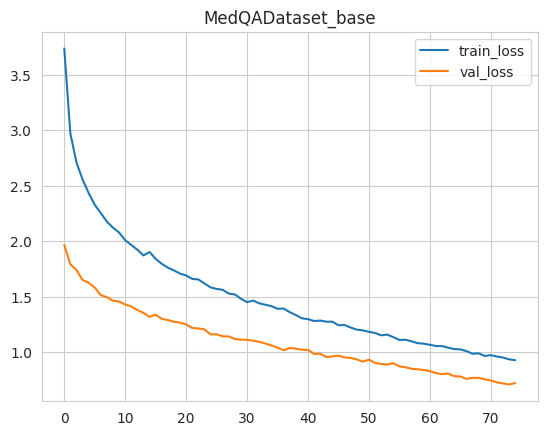

In [40]:
plt.plot(data_loss["Train loss"], label="train_loss")
plt.plot(data_loss["Validation loss"], label="val_loss")
plt.title("MedQADataset_base")
plt.legend()
plt.show()